# Iris Plant Species Classification

## Analyze the data using the same techniques as for the last assignment.
Decide for yourself which and how to use the specific commands. Answer
the following questions in the report and include figures supporting your
answers:

### Which classes exist? Are they (roughly) balanced?

In [54]:
import itertools

import utils
import pandas as pd
import matplotlib as plt
from sklearn import preprocessing

plt.rc('font', size=16)

df = pd.read_csv('iris.csv')
utils.ratio(df, 'Name')

,samples,ratio
Name,,
Iris-setosa,50,1.0
Iris-versicolor,50,1.0
Iris-virginica,50,1.0


Classes: Iris-setosa, Iris-versicolor, Iris-virginica
They are perfectly balanced.

### Which noteworthy trends of features and relations between features as well as features and Classes do you see?

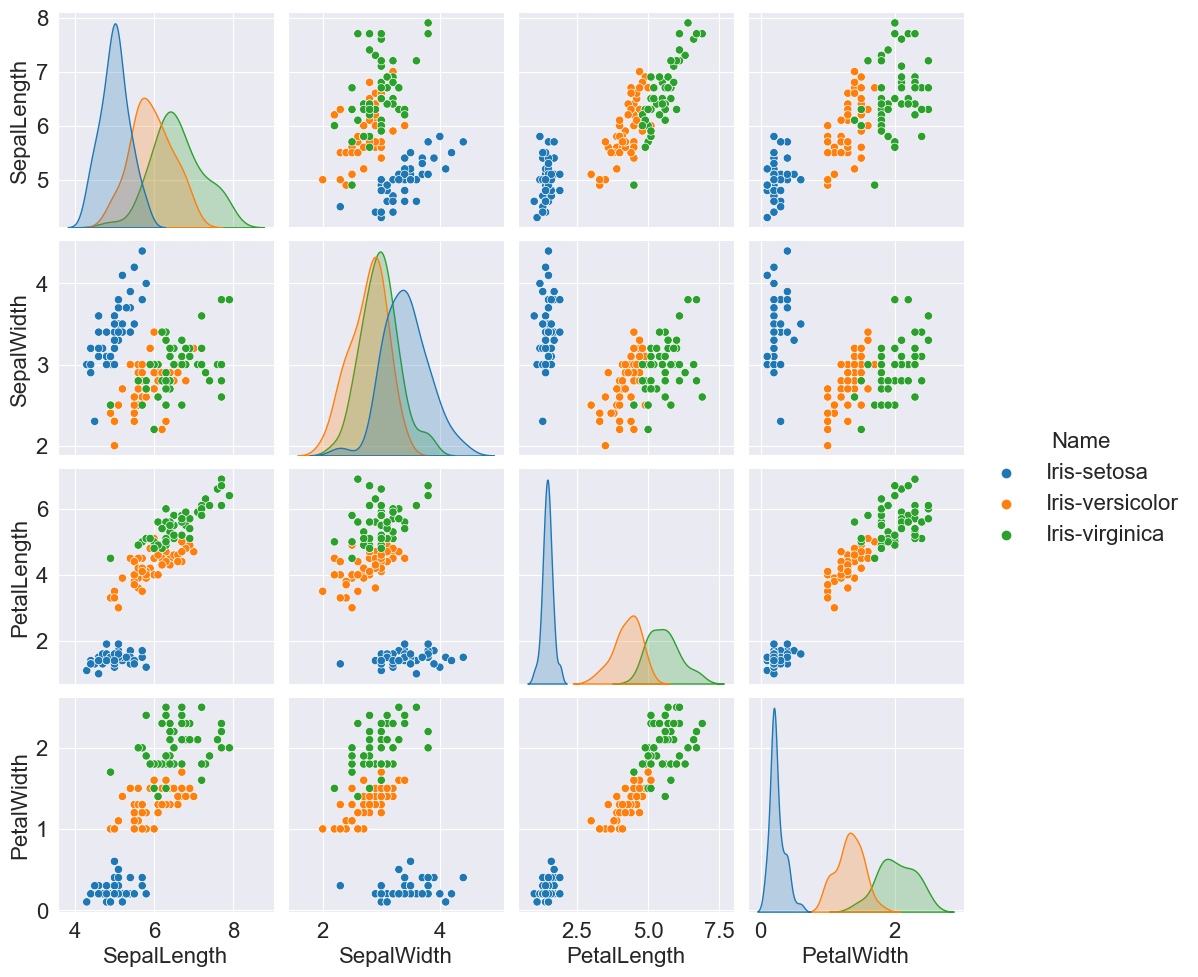

In [55]:
import seaborn as sns

sns.pairplot(df, hue='Name')

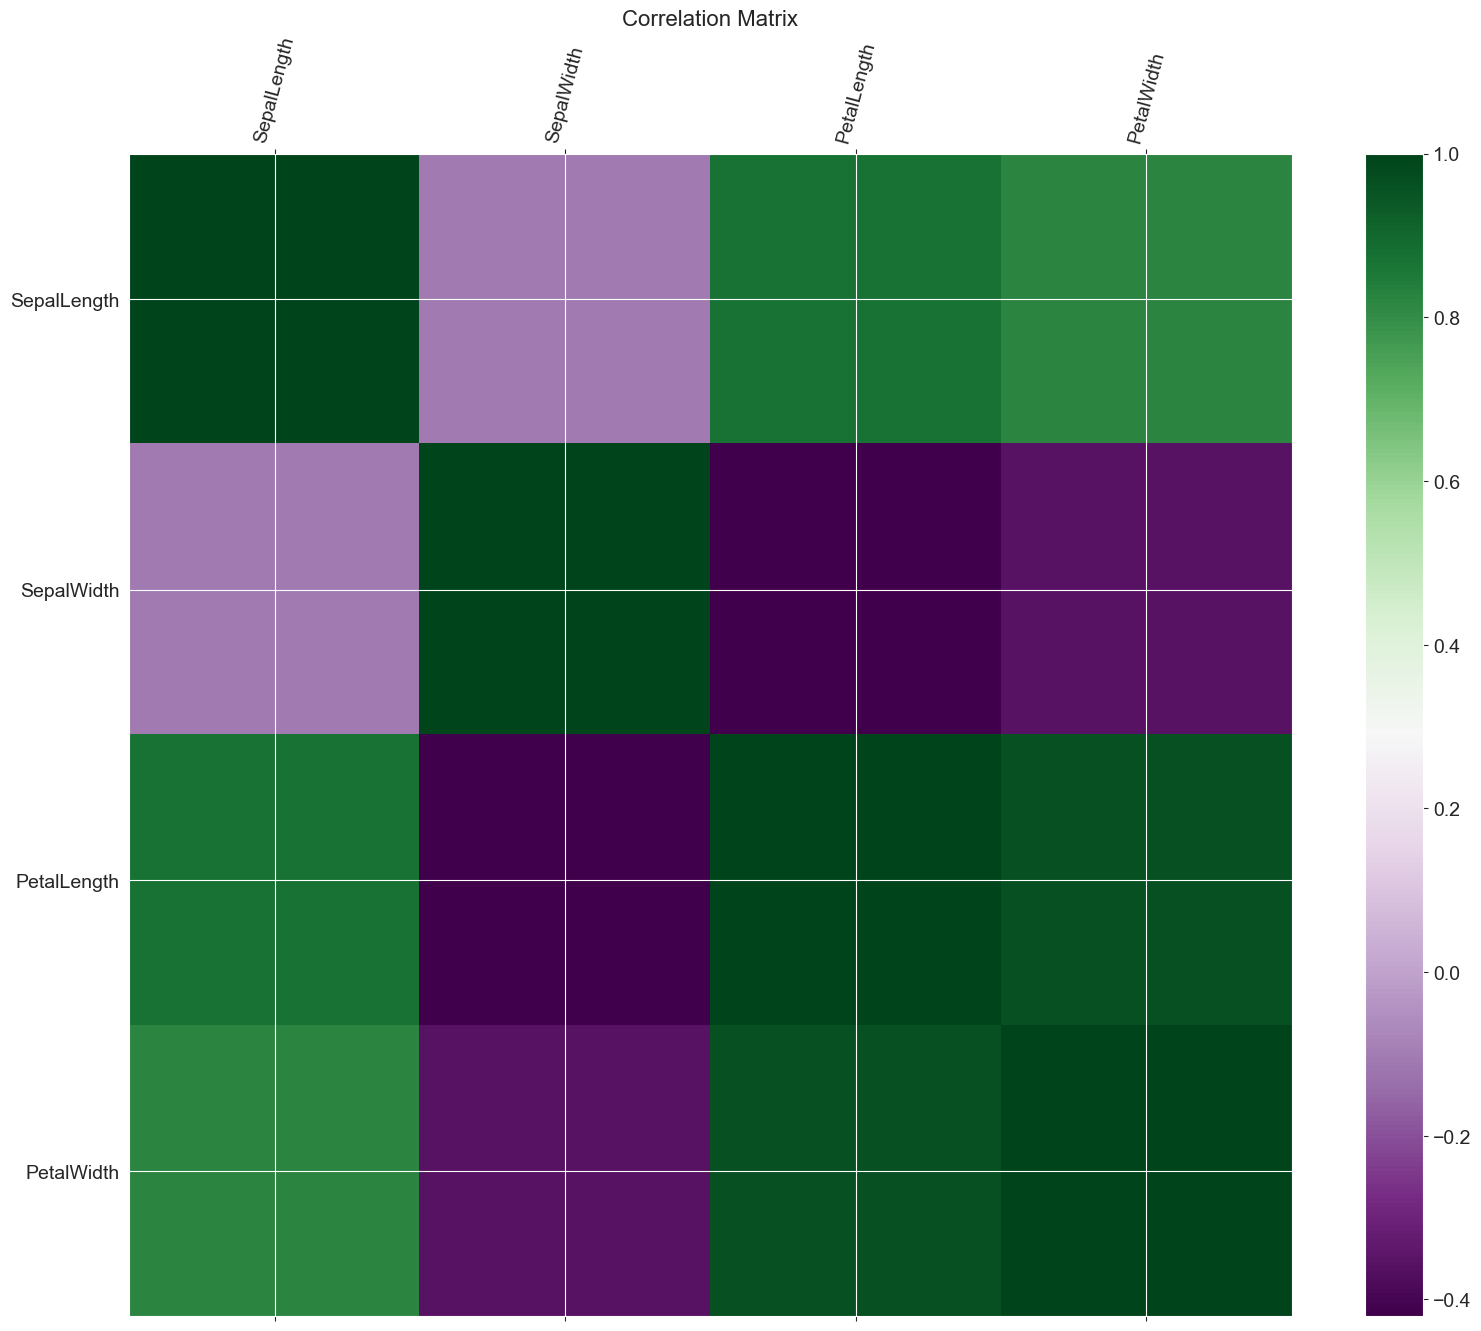

In [56]:
utils.piggy_matrix(df)

PetalLength       AxesSubplot(0.125,0.11;0.168478x0.77)
PetalWidth     AxesSubplot(0.327174,0.11;0.168478x0.77)
SepalLength    AxesSubplot(0.529348,0.11;0.168478x0.77)
SepalWidth     AxesSubplot(0.731522,0.11;0.168478x0.77)
dtype: object

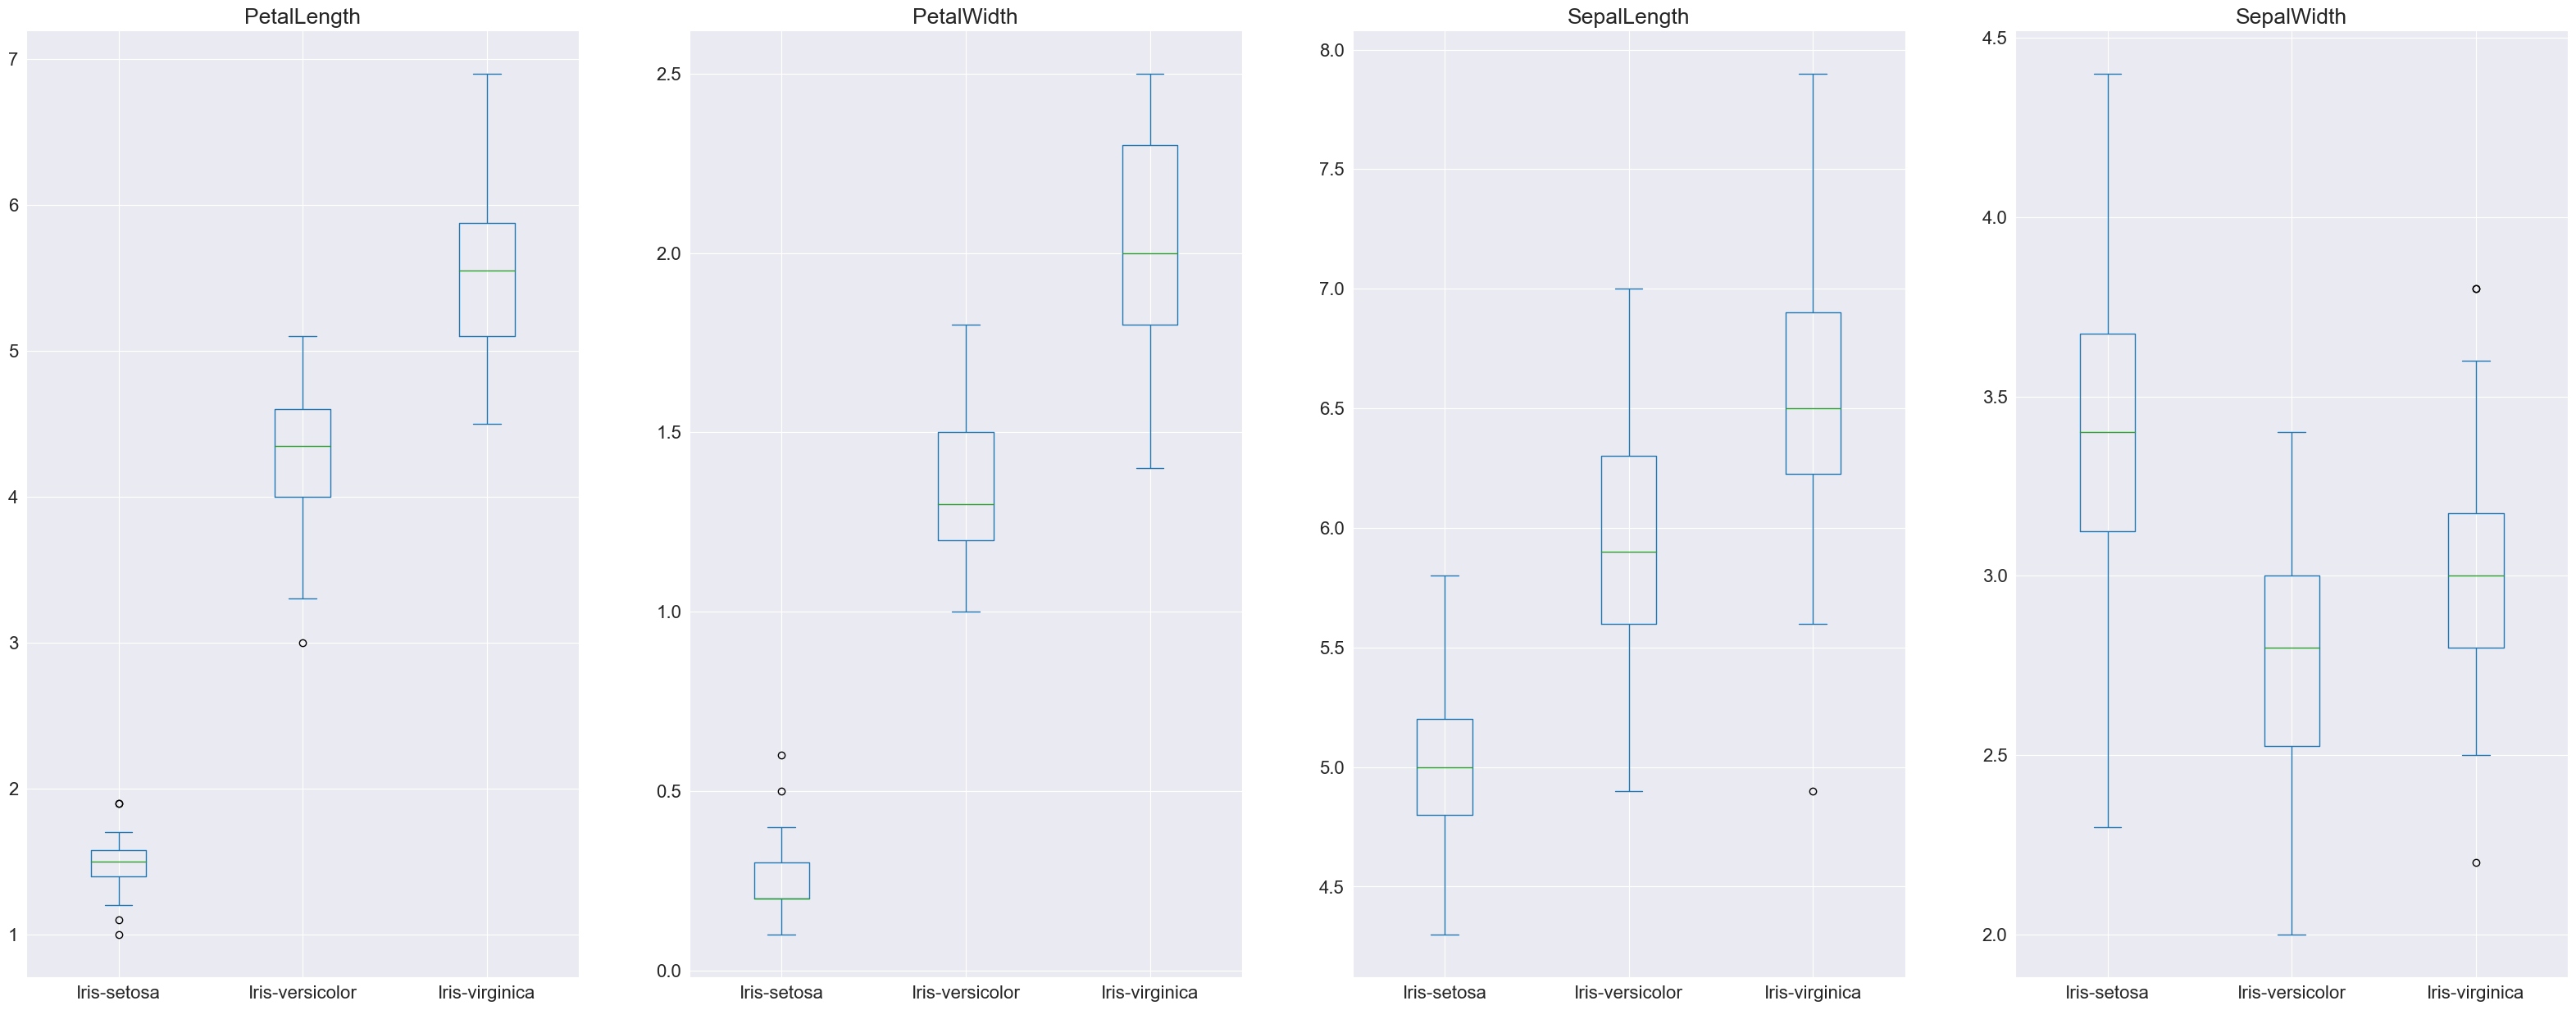

In [57]:
df.plot.box(by='Name',figsize=(40, 15), fontsize=16)

PetalLength and PetalWidth correlate well.
PetalLength and SepalWidth correlate negatively. (see correlation matrix above)
PetalLength and PetalWidth are well segmented and can be used to distinguish.

### If you would need to distinguish the classes with those features, which features would you choose, any why?

PetalLength and PetalWidth because they don't overlap significantly. (see boxplot above)
SepalLength and SepalWidth are not ideal to distinguish between flowers, since these features tend to overlap more, than any other feature.

## In order to classify the three different Iris plant species, set up your first
ML toolchain including the following steps:

### Data and Feature Preprocessing (if necessary and applicable)
* Are there any outliers in the data which might need to be removed?

In [58]:
X = df[['PetalLength', 'PetalWidth', 'SepalLength', 'SepalWidth']]
X.describe()

,PetalLength,PetalWidth,SepalLength,SepalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,3.758667,1.198667,5.843333,3.054000
std,1.764420,0.763161,0.828066,0.433594
min,1.000000,0.100000,4.300000,2.000000
25%,1.600000,0.300000,5.100000,2.800000
50%,4.350000,1.300000,5.800000,3.000000
75%,5.100000,1.800000,6.400000,3.300000
max,6.900000,2.500000,7.900000,4.400000


As we can see from the boxplot and the describe info, we do have some outliers that we could remove. Since we only have 150 samples it is not a good idea to simply remove the outliers (probably never is). A better approach would be to fix them to the mean / median or clip the outliers to some max value.

We decided to go for the second method and simply clip the values to the 99% and 1% quantile.

In [59]:
y = df['Name']
q_max = X.quantile(.99)
q_min = X.quantile(.01)
# Outlier Removal

X.clip(lower=q_min, upper=q_max, axis=1).describe()

,PetalLength,PetalWidth,SepalLength,SepalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,3.758653,1.198667,5.842667,3.053347
std,1.760089,0.763161,0.823672,0.424997
min,1.149000,0.100000,4.400000,2.200000
25%,1.600000,0.300000,5.100000,2.800000
50%,4.350000,1.300000,5.800000,3.000000
75%,5.100000,1.800000,6.400000,3.300000
max,6.700000,2.500000,7.700000,4.151000


* Are there any missing values which need to be taken care of?

In [60]:
# NaN
df.isnull().values.any()

False

* Do you need to apply any feature preprocessing steps? (e.g Normalization, Feature Deletion/Reduction/Addition)

We do not need to apply normalization nor feature deletion but some models perform better on normalized data.
With 150 samples feature deletion does not really provide any performance benefits, but we decided to do it anyway with sklearn.

In [61]:
# Scaling
scaler = preprocessing.StandardScaler().fit(X, y)

X_scaled = scaler.transform(X)


X_scaled = pd.DataFrame(X_scaled, columns=["PetalLength", "PetalWidth", "SepalLength", "SepalWidth"])
X_scaled

,PetalLength,PetalWidth,SepalLength,SepalWidth
0,-1.341272,-1.312977,-0.900681,1.032057
1,-1.341272,-1.312977,-1.143017,-0.124958
2,-1.398138,-1.312977,-1.385353,0.337848
3,-1.284407,-1.312977,-1.506521,0.106445
4,-1.341272,-1.312977,-1.021849,1.263460
...,...,...,...,...
145,0.819624,1.447956,1.038005,-0.124958
146,0.705893,0.922064,0.553333,-1.281972
147,0.819624,1.053537,0.795669,-0.124958
148,0.933356,1.447956,0.432165,0.800654


<AxesSubplot: ylabel='Density'>

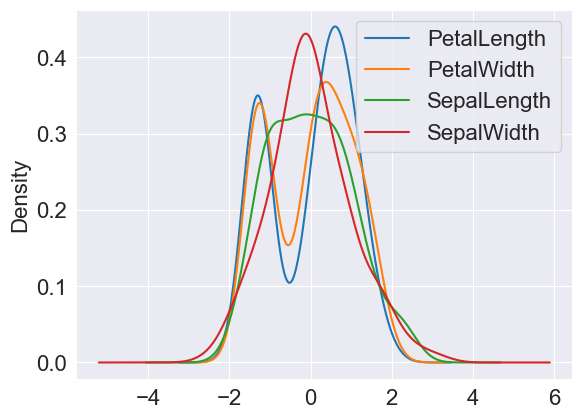

In [62]:
X_scaled.plot.density()

We decided to add some features to see if we can gain any useful information.


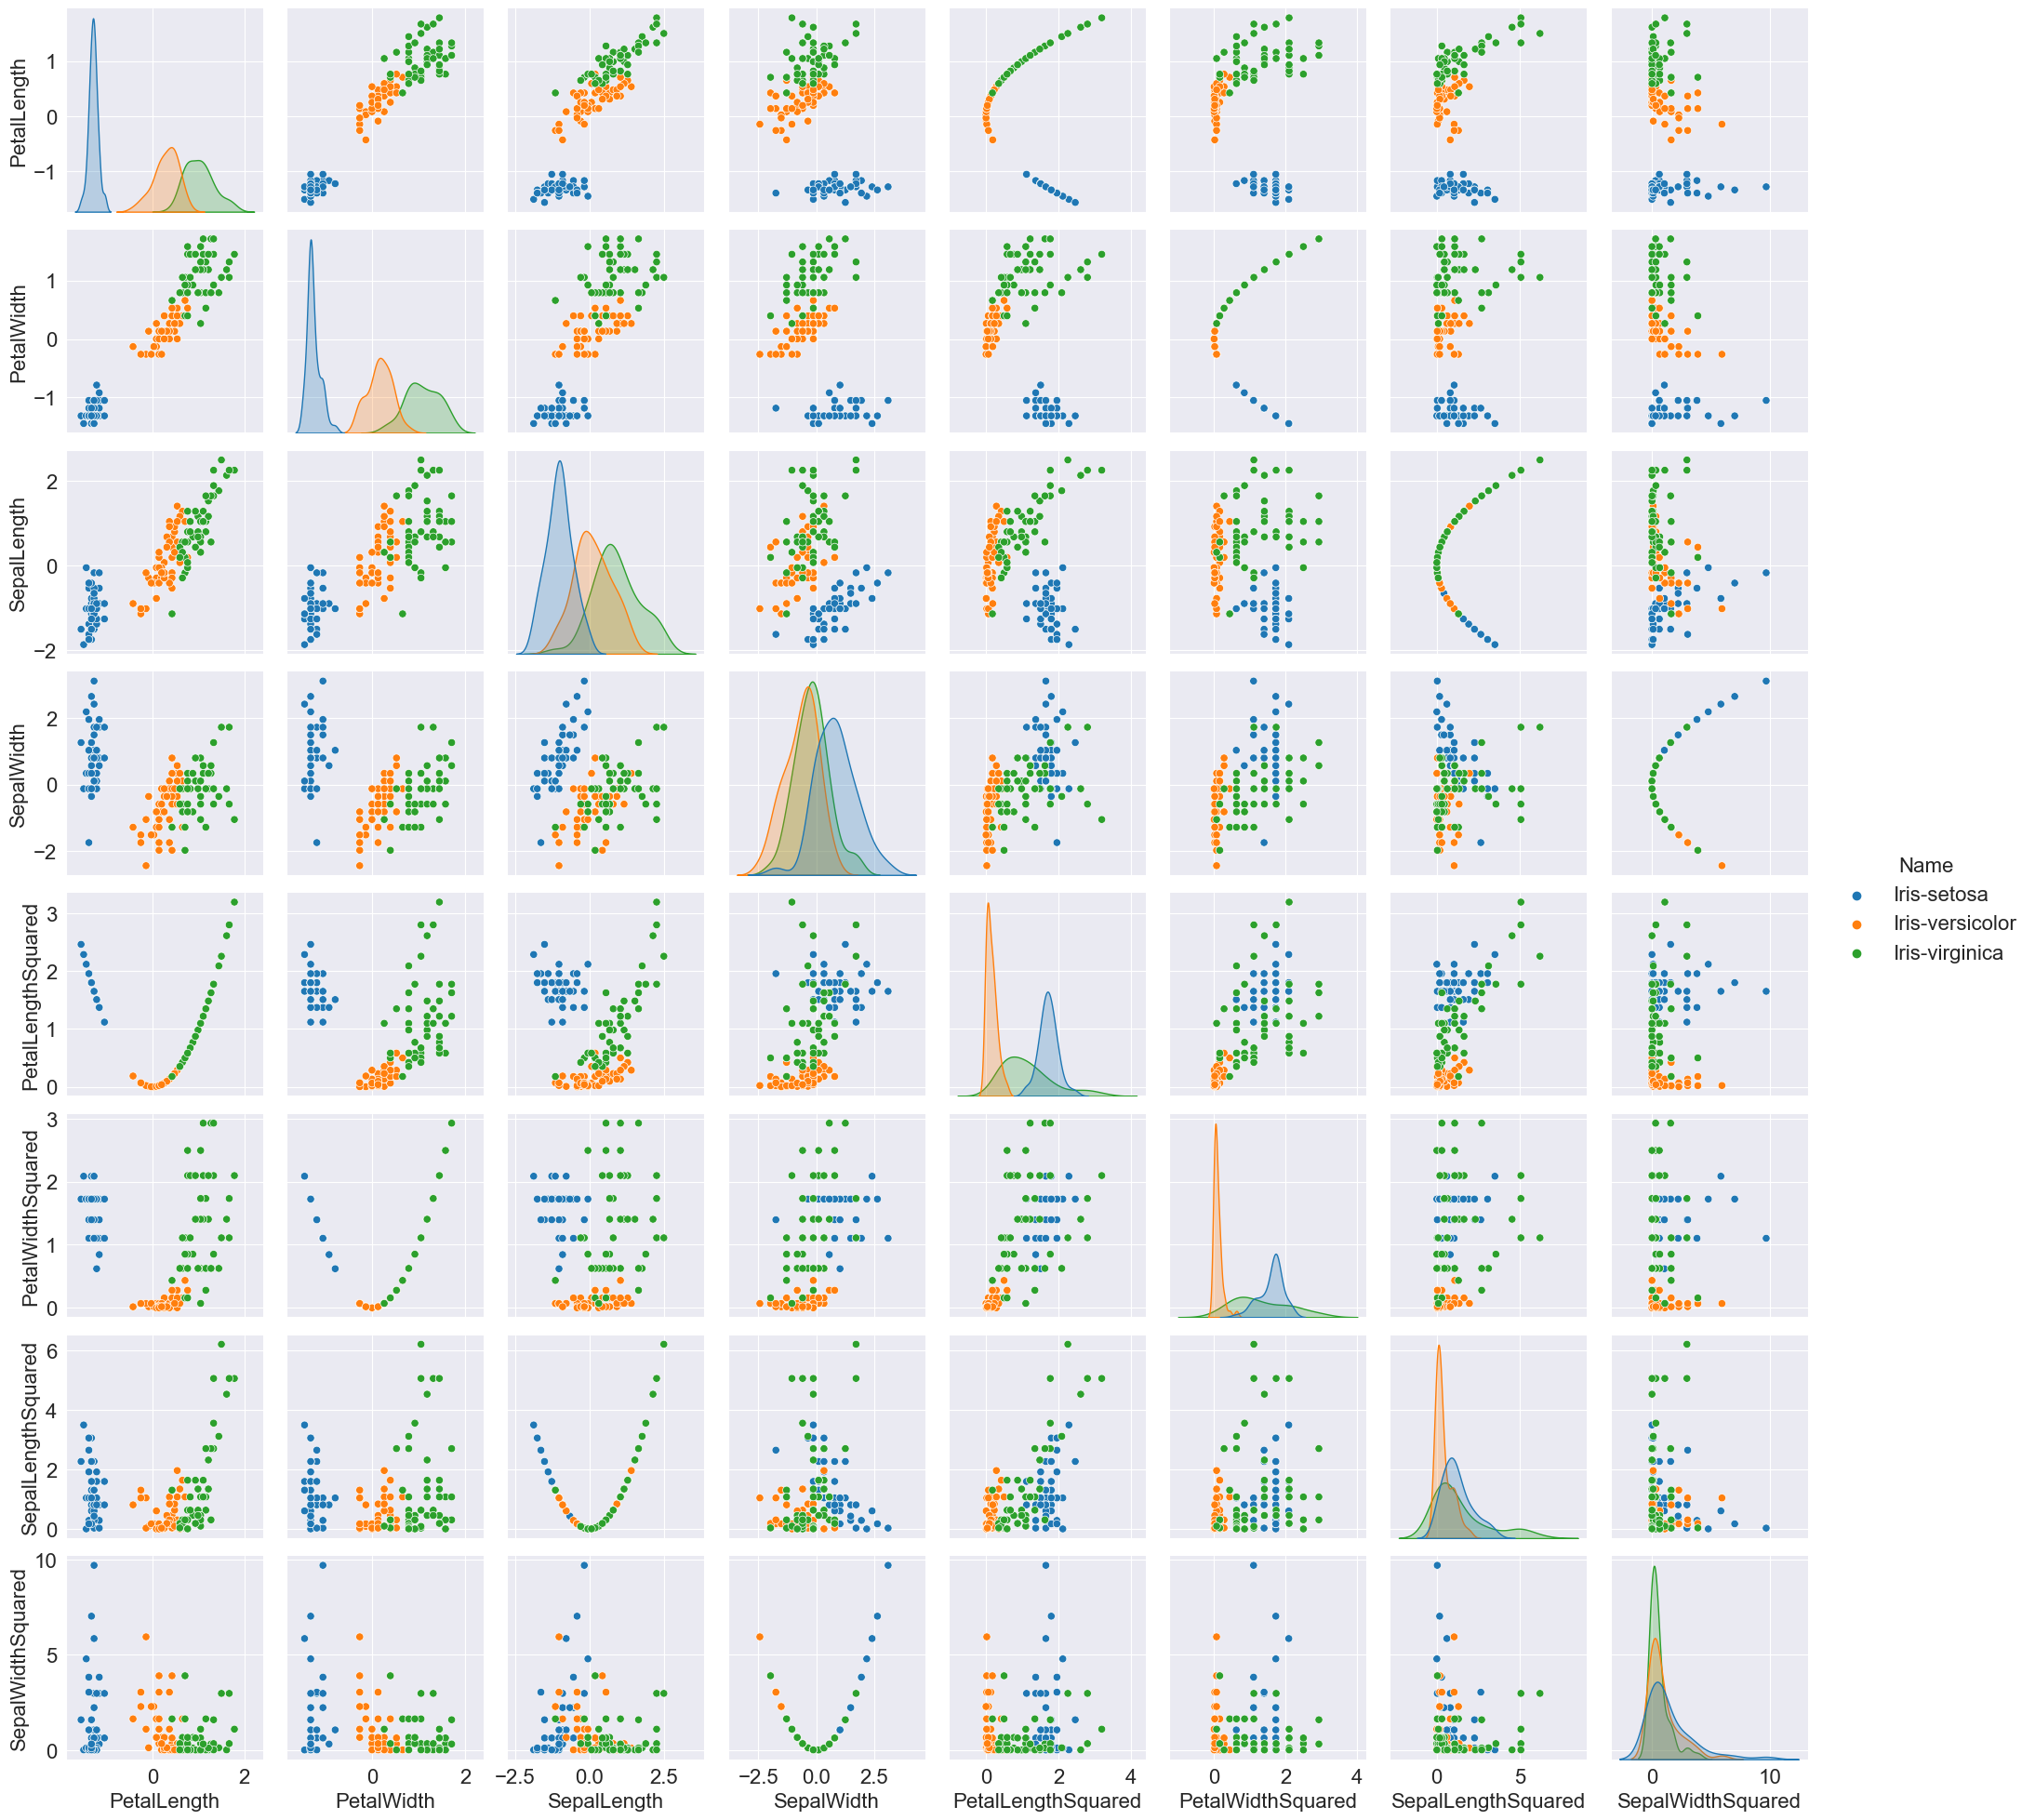

In [63]:
X_scaled["PetalLengthSquared"] = X_scaled["PetalLength"] * X_scaled["PetalLength"]
X_scaled["PetalWidthSquared"] = X_scaled["PetalWidth"] * X_scaled["PetalWidth"]
X_scaled["SepalLengthSquared"] = X_scaled["SepalLength"] * X_scaled["SepalLength"]
X_scaled["SepalWidthSquared"] = X_scaled["SepalWidth"] * X_scaled["SepalWidth"]

X_scaled["Name"] = y
sns.pairplot(X_scaled, hue="Name")
X_scaled.drop(columns=["Name"], inplace=True)  # remove target

In the lecture we learned that feture selection like PCA or LDA should only be applied to the training data and not the test data, so we need to split our data now, we used a 30/70 split where we use 70% of our data for training and 30% for validation.

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.30)  # 70/30 split

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_train

array([[ 1.54630128e+00,  5.78933918e-01, -2.12137105e+00,
         2.11733745e-01],
       [-4.58131137e-01, -1.71956305e+00, -5.69808957e-01,
         1.61292018e-01],
       [-1.19594108e+00, -1.22069506e+00, -2.81265412e-01,
        -6.39334540e-01],
       [-1.68502307e+00, -3.52013163e-01,  1.71013149e-01,
        -7.15865299e-01],
       [ 1.91707350e+00,  1.28871015e+00, -1.55009466e+00,
         6.69570579e-01],
       [-2.02988331e+00,  1.22035810e+00,  1.39954104e-01,
        -1.12662189e+00],
       [-1.27568961e+00, -1.11981178e+00, -2.34408575e-01,
        -6.35445172e-01],
       [ 2.12869759e+00,  4.27310945e-01, -9.69857711e-01,
        -3.28317522e-01],
       [ 1.43259040e+00,  4.46585404e-01, -2.06455567e+00,
         4.67480824e-01],
       [-2.62281942e+00,  2.28191488e+00,  5.55117238e-01,
         1.05897201e+00],
       [ 2.80836337e+00,  4.30494560e-01,  7.06577402e-02,
        -8.26970021e-01],
       [-1.07037308e+00, -1.22176205e+00, -1.67324400e-01,
      

* Are there any categorical features that need to be transformed so that it can be used for classification task?

 No since all our features are numerical, we do not have any categorical features.

* Do you think it makes sense to derive any more features from the given ones? Why/why not?

It could make sense, depending on the data. It is possible to generate information that can help a model perform better. Since we do not have a lot of samples we can definitely try to derive new features.

* Split up the dataset into a training and a separate held back test set in a clever way
    * Why is such a train/test split important?
        * A: So we can validate our model and check whether we just made a lookup table of our data. It's our last safety line and important to measure the performance of our model.
    * Which train/test split percentage do you choose and why?
        * A: we choose a 70/30 split since we do not have a lot of samples and want enough data to validate our model and 70 / 30 % of 150 are integers.
    * Think about how can you make sure to include samples from all three classes in both datasets and why this is important.
        * A: If a class has no samples in our training data, the model can at best make a wild guess if a sample of that class is passed to the model. We ensured that every class is represented by using `sklearn.model_selection.train_test_split` and supplying it with the `stratify` parameter.

`X_train` and `y_train` represents our training data and `X_train` and `y_train` our held back test set.

* Train different classification models to distinguish between the three Iris Plant Species:
    * Use the following models: k Nearest Neighbour, Decision Tree, Support Vector Machine

In [66]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn import svm, neighbors, neural_network
from sklearn.metrics.pairwise import distance_metrics
import itertools


knn = GridSearchCV(
    estimator= neighbors.KNeighborsClassifier(),
    param_grid= [{'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'leaf_size': [15, 20]}],
    scoring= "accuracy",
    cv= 3)

knn.fit(X_train, y_train)
knn.best_params_

{'leaf_size': 15, 'n_neighbors': 3, 'weights': 'uniform'}

In [67]:
knn.score(X_test, y_test)

0.9111111111111111

We wanted to try Nested Cross Validation, but we thought that 150 samples is not enough for that so we just used a Cross Validation with 3 partitions since more than 5 partitions always achieved 100% when using knn.
TODO: cross validate

In [68]:
from sklearn.tree import DecisionTreeClassifier

tree = GridSearchCV(
    estimator= DecisionTreeClassifier(),
    param_grid= [{
        'splitter': ['best', 'random'],
        'max_depth': [10, 100, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'class_weight': ['balanced']}],
        scoring= "accuracy",
        cv= 3
    )

tree.fit(X_train, y_train)
tree.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'splitter': 'random'}

In [69]:
tree.score(X_test, y_test)

0.8

In [70]:
from sklearn.utils.fixes import loguniform

svc = GridSearchCV(
    estimator= svm.SVC(),
    param_grid= [{
        'C': loguniform(0.1, 1, 100, 1000).rvs(20),
        'class_weight': ['balanced'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': loguniform(0.000035, 0.000245).rvs(20)
    }]
)

svc.fit(X_train, y_train)
svc.best_params_

{'C': 209.3205608327344,
 'class_weight': 'balanced',
 'gamma': 0.00017952907997917622,
 'kernel': 'linear'}

In [71]:
svc.score(X_test, y_test)

0.9111111111111111

In [ ]:

nn = GridSearchCV(
    estimator=neural_network.MLPClassifier(),
    param_grid= [{
        'hidden_layer_sizes': [(3)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adm'],
        'learning_rate': ['constant', 'ínvscaling', 'adaptive']
    }]
)

nn.fit(X_train, y_train)
nn.best_params_

C:\00-hagenberg\01-semester\ml\mc-ml\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\00-hagenberg\01-semester\ml\mc-ml\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\00-hagenberg\01-semester\ml\mc-ml\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs fa

* Use different hyperparameter settings for each model and explain why and how you chose them

* Use an appropriate cross-validation setup for the training

* Estimate the models’ performances on the held back test set:

* Compare the models with their hyperparameter settings with two different error/performance measures * Why did you chose the specific error/performance measures? * What do they tell you?

  - Which model performs best with which hyperparameter settings and why do you think it does that way?

* Explain which model you would use in deployment and why